In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from itertools import cycle
from scipy.integrate import solve_ivp

In [2]:
def Θ(x, x_rev, λ, θ):
    xk, xj = np.meshgrid(x, x)
    return (xj - x_rev)/(1 + np.exp(-λ*(xk - θ)))

In [3]:
def dΘ_dx(x, λ, θ):
    final = np.ones((x.size, x.size))/(1 + np.exp(-λ*(x - θ)))
    np.fill_diagonal(final, final.diagonal() + x*λ*np.exp(-λ*(x - θ))/(1+np.exp(-λ*(x - θ)))**2)
    return final

In [4]:
def hr_dots(current, _, b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2):
    x, y, z = map(lambda k: k.flatten(), np.split(current, 3))
    theta = Θ(x, x_rev, λ, θ)
    dots = np.zeros_like(current).reshape(3, -1)
    dots[0] = y - (x**3) + b*(x**2) + i0 - z - (α/n1)*np.sum(G1*theta, axis=1) - (β/n2)*np.sum(G2*theta, axis=1)
    dots[1] = 1 - 5*(x**2) - y
    dots[2] = μ*(s*(x - x_rest) - z)
    return np.hstack([dots[i] for i in range(3)])

In [5]:
def jac(_, y_in):
    x, y, z = map(lambda k: k.flatten(), np.split(y_in, 3))
    dtheta_dx = dΘ_dx(x, λ, θ)
    dẋ_dx = -3*x**2 + 2*b*x - (α/n1)*G1*dtheta_dx - (β/n2)*G2*dtheta_dx
    dẋ_dy = np.ones_like(dẋ_dx)
    dẋ_dz = -np.ones_like(dẋ_dy)

    dẏ_dx = -10*x*np.ones_like(dẋ_dz)
    dẏ_dy = -np.ones_like(dẏ_dx)
    dẏ_dz = np.zeros_like(dẏ_dy)

    dż_dx = μ*s*np.ones_like(dẏ_dz)
    dż_dy = np.zeros_like(dż_dx)
    dż_dz = -μ*np.ones_like(dż_dy)

    j_x = [dẋ_dx, dẋ_dy, dẋ_dz]
    j_y = [dẏ_dx, dẏ_dy, dẏ_dz]
    j_z = [dż_dx, dż_dy, dż_dz]

    return np.vstack([np.hstack(j_x), np.hstack(j_y), np.hstack(j_z)])

In [6]:
def cortex_size(mask, val):
    return int(np.sqrt(mask[mask == val].shape))

In [7]:
def plot_final_state(
    y,
    cortices=None, legend=False,
    title=None, channel=0,
    markers=["ro", "k^", "gX", "bD"],
    ylim=[-1.5, 2.5]
):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    for cortex in cortices:
        plt.plot(range(*cortex), y[-1, channel, cortex[0]:cortex[1]], next(m), label=f"{cortex[0]} - {cortex[1] - 1}")
    if legend:
        plt.legend(loc="best")
    if title:
        plt.title(title)
    plt.ylim(ylim)

In [8]:
def plot_beginning_and_end(y, start, end, p=0.99, legend=False, title=True, channel=0):
    l = y.shape[0]
    fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True)
    for i in range(start, end):
        ax1.plot(y[:int(p*l), channel, i], label=i)
        ax1.grid(True)
        ax1.set_xlim([0, int(p*l)])
        ax2.plot(y[int((1 - p)*l):, channel, i], label=i)
        ax2.grid(True)
        ax2.set_xlim([0, int(p*l)])
        plt.ylim([-1.5, 2.25])
    if legend:
        ax1.legend(loc="lower left")
    if title:
        plt.suptitle(f"First and last {100*p}\% of neurons {start} - {end}")

In [9]:
def plot_state_diagram(y, cortices=None, lim=[-1.5, 2.5], markers=["ro", "k^", "gX", "bD"]):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    ytp1 = y[:-1]
    yt = y[1:]
    for cortex in cortices:
        plt.plot(yt[cortex[0]:cortex[1]], ytp1[cortex[0]:cortex[1]], next(m))
    plt.xlim(lim)
    plt.ylim(lim)

In [10]:
cortices = [[0, 18],
            [18, 28],
            [28, 46],
            [46, 65]]

In [11]:
n = np.loadtxt("../connectomes/cat_connectome")/3
cortex_mask = np.zeros_like(n)
cortex_mask[:18, :18] = 1
cortex_mask[18:28, 18:28] = 2
cortex_mask[28:46, 28:46] = 3
cortex_mask[46:, 46:] = 4
G1 = n.copy()
G1[cortex_mask == 0] = 0
G2 = n.copy()
G2[cortex_mask != 0] = 0

In [12]:
# For validation
for i in [1, 2, 3, 4]:
    print(i, cortex_size(cortex_mask, i))

1 18
2 10
3 18
4 19


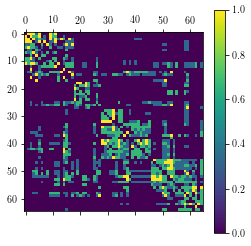

In [13]:
plt.matshow(n)
plt.colorbar()

In [14]:
n[45:, 45:].shape

(20, 20)

In [15]:
b = 3.2                           # Controls spiking frequency
i0 = 4.4*np.ones(n.shape[0])      # Input current ---- It's an array so we can add noise later
x_rev = 2                         # Reverse potential
λ = 10                            # Sigmoidal function parameter
θ = -0.25                         # Sigmoidal function parameter
μ = 0.01                          # Time scale of slow current
s = 4.0                           # Governs adaptation (whatever that means)
x_rest = -1.6                     # Resting potential ------ INCORRECT IN SANTOS PAPER
α = 0.210                         # Intra connection strength ---- VARIED PARAMETER
n1 = np.count_nonzero(G1, axis=1) # Number of intra connections from a given neuron
n1[n1 == 0] = 1                   # This is to remove a divide-by-zero; if n1 is 0, then so is G1
β = 0.040                         # Inter connection strength ---- VARIED PARAMETER
n2 = np.count_nonzero(G2, axis=1) # Number of inter connections from a given neuron
n2[n2 == 0] = 1                   # This is to remove a divide-by-zero; if n2 is 0, then so is G2

In [16]:
ivs = np.zeros([3, n.shape[0]])   # Initial values [[x], [y], [z]]
ivs[0] = 4*np.random.random(n.shape[0]) - 2
ivs[1] = 0.2*np.random.random(n.shape[0])
ivs[2] = 0.2*np.random.random(n.shape[0])

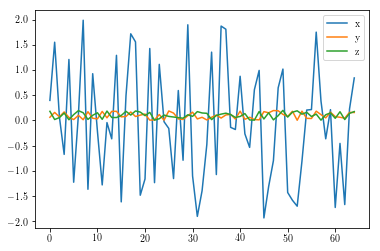

In [17]:
plt.plot(ivs[0], label="x")
plt.plot(ivs[1], label="y")
plt.plot(ivs[2], label="z")
plt.legend()

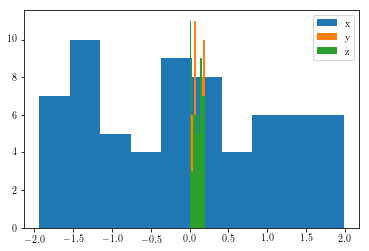

In [18]:
plt.hist(ivs[0], label="x")
plt.hist(ivs[1], label="y")
plt.hist(ivs[2], label="z")
plt.legend()

In [19]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [20]:
tmax = 4000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [21]:
%%time
sol_sync = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                     t_span=(0, tmax), y0=ivs.reshape(ivs.size),
                     dense_output=True, method="RK45")

CPU times: user 28.6 s, sys: 164 ms, total: 28.7 s
Wall time: 29 s


In [22]:
tmax/len(sol_sync.t)

0.303905181583346

In [23]:
vals_sync = sol_sync.sol(t).T
vals_sync = vals_sync.reshape(-1, 3, 65)
vals_sync.shape

(400000, 3, 65)

In [24]:
# with open("../data/vals_sync.pkl", "wb") as f:
#     pickle.dump(vals_sync, f)

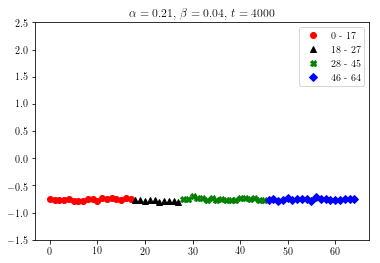

In [25]:
plot_final_state(y=vals_sync, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

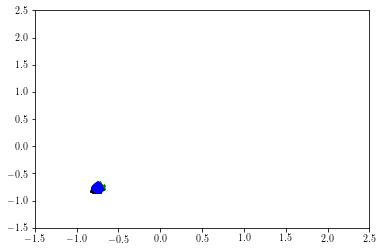

In [26]:
plot_state_diagram(vals_sync[-1, 0, :], cortices=cortices)

In [27]:
p = 0.01

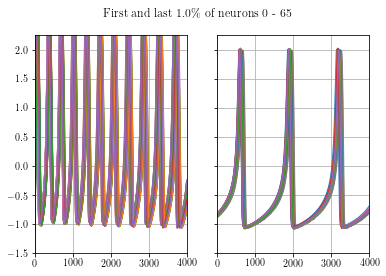

In [28]:
plot_beginning_and_end(vals_sync, 0, 65, p=p)

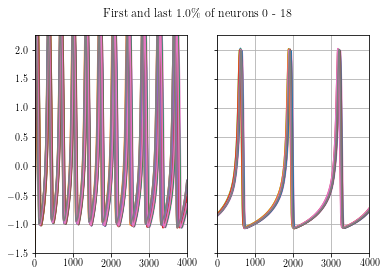

In [29]:
plot_beginning_and_end(vals_sync, 0, 18, p=p)

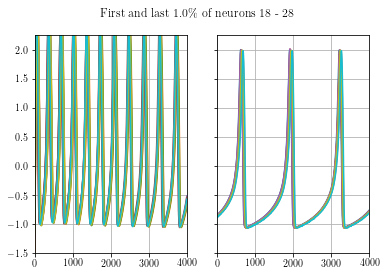

In [30]:
plot_beginning_and_end(vals_sync, 18, 28, p=p)

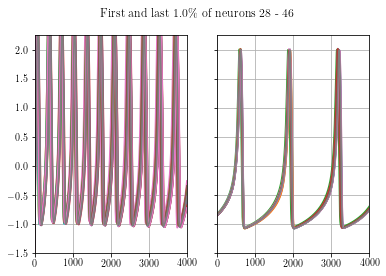

In [31]:
plot_beginning_and_end(vals_sync, 28, 46, p=p)

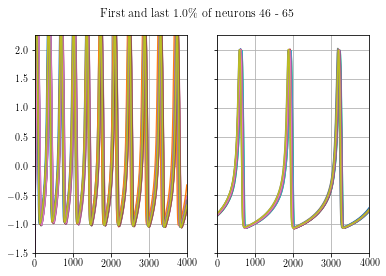

In [32]:
plot_beginning_and_end(vals_sync, 46, 65, p=p)

In [33]:
α = 0.001
β = 0.001

In [34]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [35]:
%%time
sol_async = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                      t_span=(0, tmax), y0=ivs.reshape(ivs.size),
                      dense_output=True, method="RK45")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 47.6 s, sys: 316 ms, total: 47.9 s
Wall time: 49.9 s


In [36]:
tmax/len(sol_async.t)

0.19743336623889438

In [37]:
vals_async = sol_async.sol(t).T
vals_async = vals_async.reshape(-1, 3, 65)
vals_async.shape

(400000, 3, 65)

In [38]:
# with open("../data/vals_async.pkl", "wb") as f:
#     pickle.dump(vals_async, f)

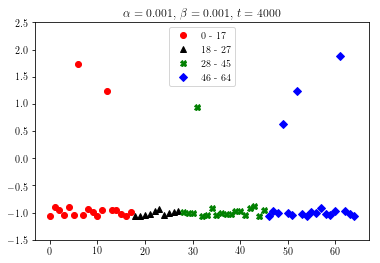

In [39]:
plot_final_state(y=vals_async, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

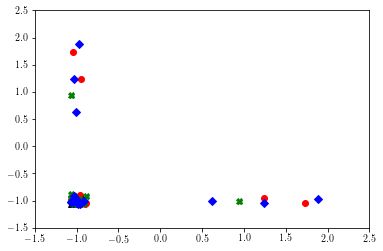

In [40]:
plot_state_diagram(vals_async[-1, 0, :], cortices=cortices)

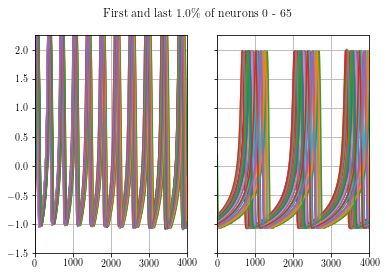

In [41]:
plot_beginning_and_end(vals_async, 0, 65, legend=False, p=p)

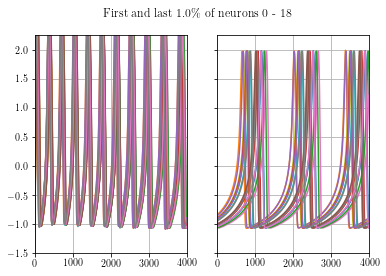

In [42]:
plot_beginning_and_end(vals_async, 0, 18, p=p)

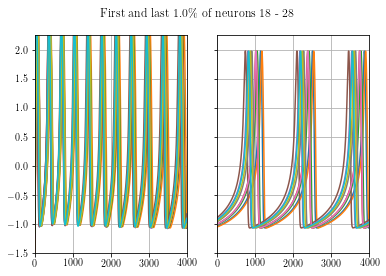

In [43]:
plot_beginning_and_end(vals_async, 18, 28, p=p)

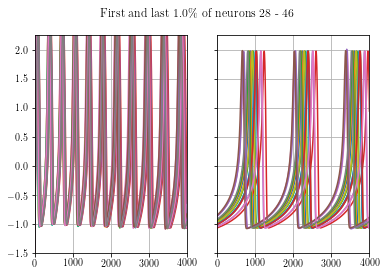

In [44]:
plot_beginning_and_end(vals_async, 28, 46, p=p)

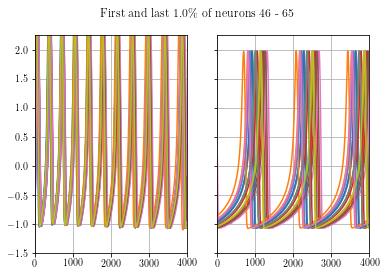

In [45]:
plot_beginning_and_end(vals_async, 46, 65, p=p)

In [46]:
α = 0.7
β = 0.08

In [47]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [48]:
%%time
sol_sc = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                   t_span=(0, tmax), y0=ivs.reshape(ivs.size),
                   dense_output=True, method="RK45")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 43.9 s, sys: 170 ms, total: 44.1 s
Wall time: 44.4 s


In [49]:
tmax/len(sol_sc.t)

0.21127132519938732

In [50]:
vals_sc = sol_sc.sol(t).T
vals_sc = vals_sc.reshape(-1, 3, 65)
vals_sc.shape

(400000, 3, 65)

In [51]:
# with open("../data/vals_sc.pkl", "wb") as f:
#     pickle.dump(vals_sc, f)

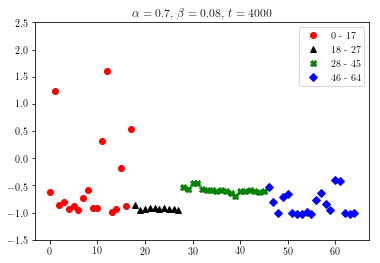

In [52]:
plot_final_state(y=vals_sc, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

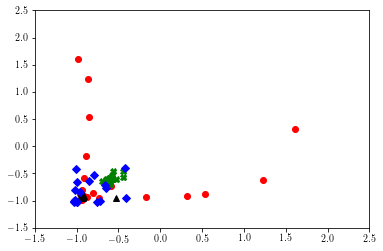

In [53]:
plot_state_diagram(vals_sc[-1, 0, :], cortices=cortices)

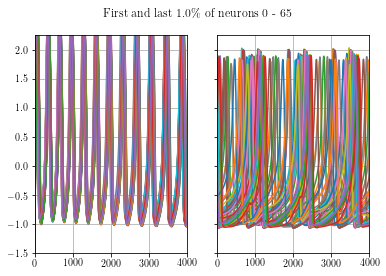

In [54]:
plot_beginning_and_end(vals_sc, 0, 65, legend=False, p=p)

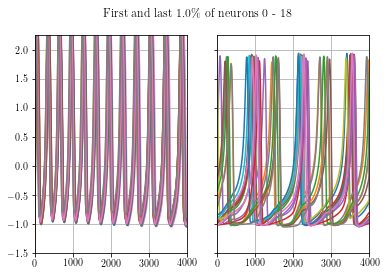

In [55]:
plot_beginning_and_end(vals_sc, 0, 18, p=p)

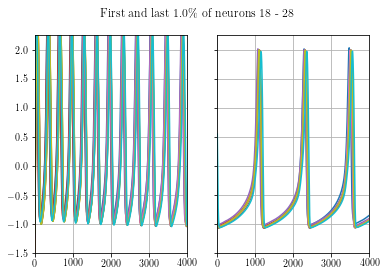

In [56]:
plot_beginning_and_end(vals_sc, 18, 28, p=p)

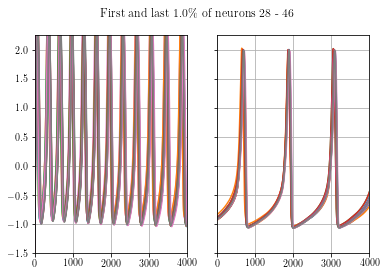

In [57]:
plot_beginning_and_end(vals_sc, 28, 46, p=p)

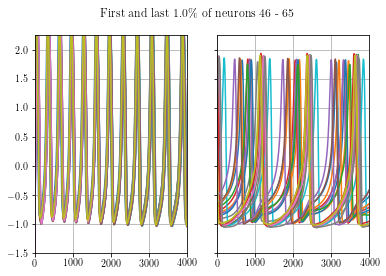

In [58]:
plot_beginning_and_end(vals_sc, 46, 65, p=p)

In [59]:
α = 1.5
β = 0.1

In [60]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [61]:
%%time
sol_bc = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                   t_span=(0, tmax), y0=ivs.reshape(ivs.size),
                   dense_output=True, method="RK45")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 59.2 s, sys: 829 ms, total: 1min
Wall time: 1min 18s


In [62]:
tmax/len(sol_bc.t)

0.20181634712411706

In [63]:
vals_bc = sol_bc.sol(t).T
vals_bc = vals_bc.reshape(-1, 3, 65)
vals_bc.shape

(400000, 3, 65)

In [64]:
# with open("../data/vals_bc.pkl", "wb") as f:
#     pickle.dump(vals_bc, f)

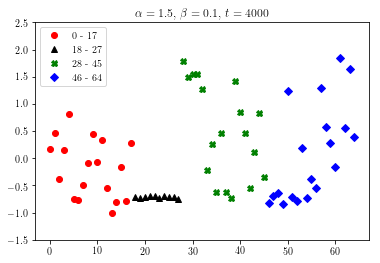

In [65]:
plot_final_state(y=vals_bc, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

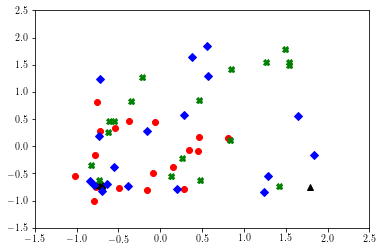

In [66]:
plot_state_diagram(vals_bc[-1, 0, :], cortices=cortices)

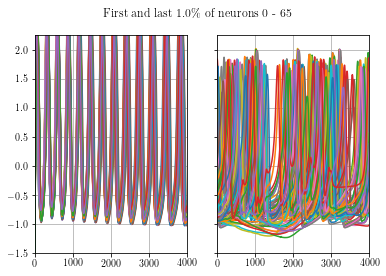

In [67]:
plot_beginning_and_end(vals_bc, 0, 65, legend=False, p=p)

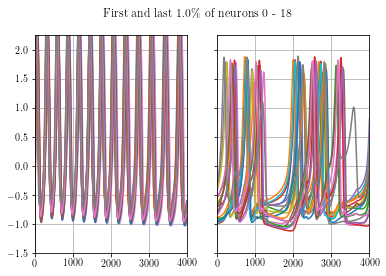

In [68]:
plot_beginning_and_end(vals_bc, 0, 18, p=p)

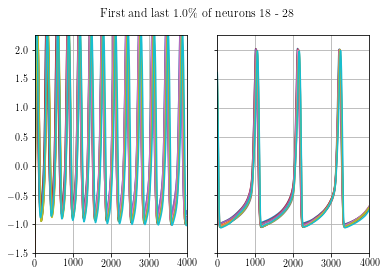

In [69]:
plot_beginning_and_end(vals_bc, 18, 28, p=p)

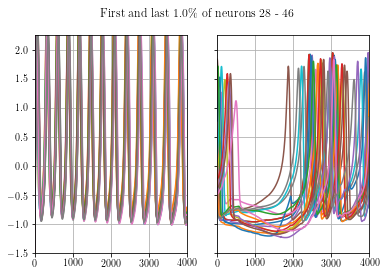

In [70]:
plot_beginning_and_end(vals_bc, 28, 46, p=p)

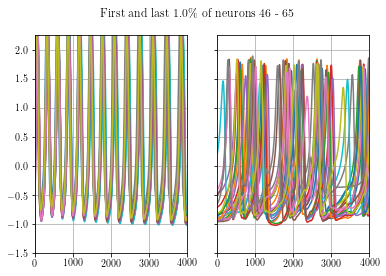

In [71]:
plot_beginning_and_end(vals_bc, 46, 65, p=p)